In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

def load_data():
    df = pd.read_excel(r"D:\company_data.xlsx", sheet_name='Data')
    return df

In [15]:
df.columns


Index(['Order ID', 'Order Date', 'Unit Cost', 'Price', 'Order Qty',
       'Cost of Sales', 'Sales', 'Profit', 'Channel', 'Promotion Name',
       'Product Name', 'Manufacturer', 'Product Sub Category',
       'Product Category', 'Region', 'City', 'Country'],
      dtype='object')

In [16]:
   
def select_features_for_price(data):
    exclude_cols = ['Order ID', 'Price', 'Sales', 'Profit', 'Cost of Sales', 'Order Date']
    features = [col for col in data.columns if col not in exclude_cols]
    
    X = data[features]
    y = data['Price']
    
    return X, y

In [17]:

from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    data = df.copy()
    data['Product_Name_Original'] = data['Product Name'].copy()
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Order_Year'] = data['Order Date'].dt.year
    data['Order_Month'] = data['Order Date'].dt.month
    data['Order_Day'] = data['Order Date'].dt.day
    data['Order_DayOfWeek'] = data['Order Date'].dt.dayofweek
    data['Order_Quarter'] = data['Order Date'].dt.quarter

    categorical_cols = ['Channel', 'Promotion Name', 'Product Name', 'Manufacturer', 
                       'Product Sub Category', 'Product Category', 'Region', 'City', 'Country']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

    data.fillna(0, inplace=True)
    return data, label_encoders

def prepare_demand_data(processed_data):
    demand_data = processed_data.groupby(['Order Date', 'Product_Name_Original']).agg({
        'Order Qty': 'sum',
        'Price': 'mean',
        'Unit Cost': 'mean'
    }).reset_index()

    demand_pivot = demand_data.pivot_table(
        index='Order Date', 
        columns='Product_Name_Original', 
        values='Order Qty',
        aggfunc='sum'
    ).fillna(0)

    return demand_pivot, demand_data


In [18]:
def prepare_demand_data(processed_data, label_encoders):
    demand_data = processed_data.groupby(['Order Date', 'Product_Name_Original']).agg({
        'Order Qty': 'sum',
        'Price': 'mean',
        'Unit Cost': 'mean'
    }).reset_index()
    
    demand_pivot = demand_data.pivot_table(
        index='Order Date', 
        columns='Product_Name_Original', 
        values='Order Qty', 
        aggfunc='sum'
    ).fillna(0)
    
    return demand_pivot, demand_data

In [19]:
def train_price_models(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }
    
    results = {}
    
    for name, model in models.items():
        mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_test_scaled)
            
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            r2_scores.append(r2_score(y_test, y_pred))
            
        results[name] = {
            'model': model,
            'mae': np.mean(mae_scores),
            'mse': np.mean(mse_scores),
            'rmse': np.mean(rmse_scores),
            'r2': np.mean(r2_scores)
        }
        
        print(f"{name} Performance:")
        print(f"MAE: {results[name]['mae']:.2f}")
        print(f"MSE: {results[name]['mse']:.2f}")
        print(f"RMSE: {results[name]['rmse']:.2f}")
        print(f"R² Score: {results[name]['r2']:.4f}")
        print("-" * 50)
    
    return results

In [20]:
def forecast_demand(demand_pivot, product_name, periods=30):
    if product_name not in demand_pivot.columns:
        print(f"Product {product_name} not found in demand data")
        return None
    
    product_series = demand_pivot[product_name]
    
    product_series = product_series.replace(0, np.nan).ffill().bfill()
    try:
        arima_model = ARIMA(product_series, order=(1, 1, 1))
        arima_result = arima_model.fit()
        arima_forecast = arima_result.forecast(steps=periods)
    except:
        arima_forecast = None
    
    try:
        es_model = ExponentialSmoothing(product_series, trend='add', seasonal='add', seasonal_periods=7)
        es_result = es_model.fit()
        es_forecast = es_result.forecast(steps=periods)
    except:
        es_forecast = None
    
    return {
        'arima_forecast': arima_forecast,
        'exponential_smoothing_forecast': es_forecast,
        'historical_data': product_series
    }
    

In [21]:
def plot_feature_importance(model, feature_names, top_n=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print("Model doesn't have feature importance or coefficients")
        return
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Top Feature Importances for Price Prediction')
    plt.tight_layout()
    plt.show()

In [22]:

def plot_demand_forecast(historical_data, forecasts, product_name):
    plt.figure(figsize=(12, 6))
    
    plt.plot(historical_data.index, historical_data.values, label='Historical Demand', color='blue')
    
    last_date = historical_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(forecasts['arima_forecast']))
    if forecasts['arima_forecast'] is not None:
        plt.plot(future_dates, forecasts['arima_forecast'], label='ARIMA Forecast', color='red', linestyle='--')
    
    if forecasts['exponential_smoothing_forecast'] is not None:
        plt.plot(future_dates, forecasts['exponential_smoothing_forecast'], label='Exponential Smoothing Forecast', color='green', linestyle='--')
    
    plt.title(f'Demand Forecast for Product: {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [23]:
def predict_price(model, scaler, new_data, feature_columns):
    """
    Predict price for new data
    
    Parameters:
    model: trained model
    scaler: fitted scaler
    new_data: dictionary or DataFrame with feature values
    feature_columns: list of feature column names used in training
    """
    new_df = pd.DataFrame([new_data])
    
    for col in feature_columns:
        if col not in new_df.columns:
            new_df[col] = 0  
    
    new_df = new_df[feature_columns]
    new_scaled = scaler.transform(new_df)
    
    prediction = model.predict(new_scaled)
    
    return prediction[0]
    

Loading and preprocessing data...
Selecting features for price prediction...
Checking for non-numeric columns...
Non-numeric columns: ['Product_Name_Original']
Dropping non-numeric columns...
Training price prediction models...
Random Forest Performance:
MAE: 61.59
MSE: 23733.06
RMSE: 152.04
R² Score: 0.7990
--------------------------------------------------
Gradient Boosting Performance:
MAE: 95.37
MSE: 27516.01
RMSE: 165.58
R² Score: 0.7668
--------------------------------------------------
Linear Regression Performance:
MAE: 138.14
MSE: 50592.20
RMSE: 224.74
R² Score: 0.5704
--------------------------------------------------

Best price prediction model: Random Forest with R² score: 0.7990

Plotting feature importance for price prediction...


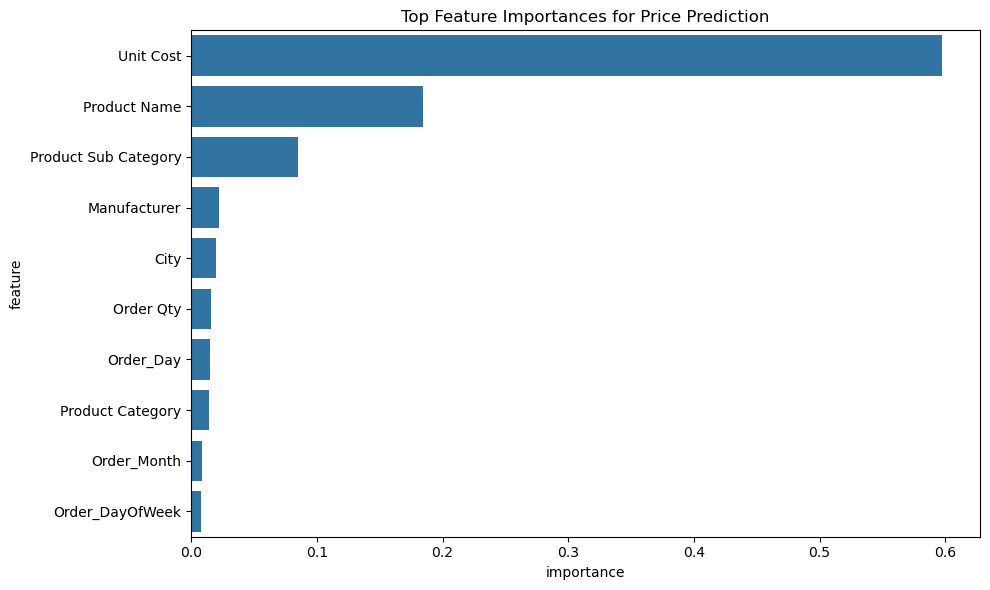


Preparing demand forecasting data...
Columns in temp_processed: ['index', 'Order ID', 'Order Date', 'Unit Cost', 'Price', 'Order Qty', 'Cost of Sales', 'Sales', 'Profit', 'Channel', 'Promotion Name', 'Product Name', 'Manufacturer', 'Product Sub Category', 'Product Category', 'Region', 'City', 'Country', 'Product_Name_Original', 'Order_Year', 'Order_Month', 'Order_Day', 'Order_DayOfWeek', 'Order_Quarter']
First few rows:
   index  Order ID Order Date   Unit Cost   Price  Order Qty  Cost of Sales  \
0      0      7077 2017-09-13   76.094968  304.00          9     684.854710   
1      1       117 2016-08-20    7.491753   12.99          4      29.967011   
2      2      7018 2016-07-08   10.122338  159.99          9      91.101039   
3      3       140 2018-08-11    0.576153   25.69         18      10.370759   
4      4       491 2017-07-15  108.508777  304.00          9     976.578991   

       Sales       Profit  Channel  ...  Product Category  Region  City  \
0  2714.7200  2029.865290

In [24]:
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    df = load_data()
    processed_data, label_encoders = preprocess_data(df)
    
    print("Selecting features for price prediction...")
    X, y = select_features_for_price(processed_data)
    
    print("Checking for non-numeric columns...")
    non_numeric_cols = X.select_dtypes(include=['object']).columns
    print("Non-numeric columns:", non_numeric_cols.tolist())

    if len(non_numeric_cols) > 0:
        print("Dropping non-numeric columns...")
        X = X.drop(columns=non_numeric_cols)
    
    print("Training price prediction models...")
    price_results = train_price_models(X, y)
    
    best_model_name = max(price_results, key=lambda x: price_results[x]['r2'])
    best_model = price_results[best_model_name]['model']
    print(f"\nBest price prediction model: {best_model_name} with R² score: {price_results[best_model_name]['r2']:.4f}")
    print("\nPlotting feature importance for price prediction...")
    plot_feature_importance(best_model, X.columns.tolist())
    
    print("\nPreparing demand forecasting data...")
    temp_processed = processed_data.reset_index()

    print("Columns in temp_processed:", temp_processed.columns.tolist())
    print("First few rows:")
    print(temp_processed.head())

    print("'Order Date' in columns:", 'Order Date' in temp_processed.columns)
    print("'Product_Name_Original' in columns:", 'Product_Name_Original' in temp_processed.columns)

    demand_pivot, demand_data = prepare_demand_data(temp_processed, label_encoders)
    product_names = demand_pivot.columns.tolist()[:5]
    print(f"Forecasting demand for {len(product_names)} products...")
    
    


Forecasting demand for product: A. Datum Advanced Digital Camera M300 Azure


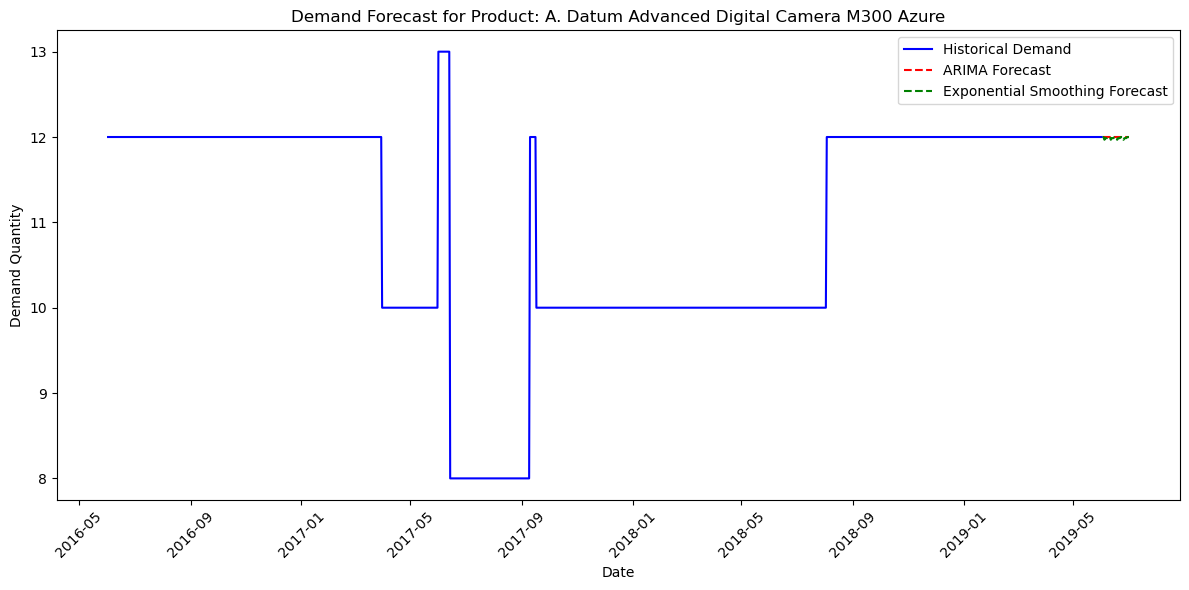

Historical demand stats for A. Datum Advanced Digital Camera M300 Azure:
  Mean: 10.99
  Std: 1.30
  Max: 13.00
ARIMA forecast mean: 12.00
Exponential Smoothing forecast mean: 11.99

Making a sample price prediction...
Predicted Price: $319.72
Actual Price: $304.00
Difference: $15.72

Forecasting demand for product: A. Datum Advanced Digital Camera M300 Black


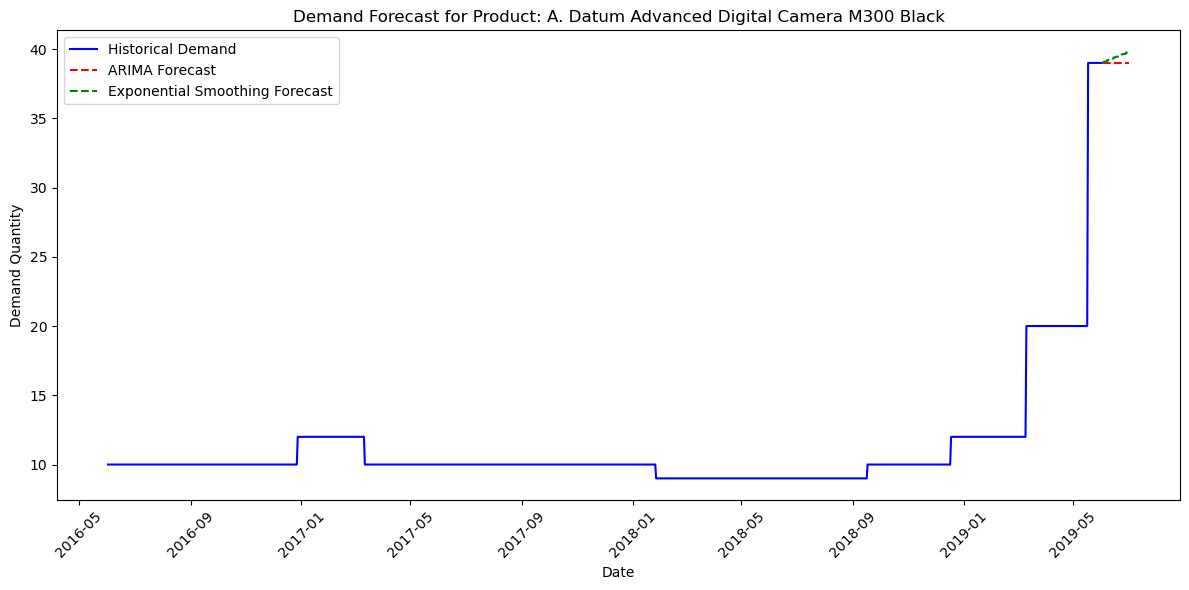

Historical demand stats for A. Datum Advanced Digital Camera M300 Black:
  Mean: 11.12
  Std: 4.25
  Max: 39.00
ARIMA forecast mean: 39.00
Exponential Smoothing forecast mean: 39.41

Making a sample price prediction...
Predicted Price: $319.72
Actual Price: $304.00
Difference: $15.72

Forecasting demand for product: A. Datum Advanced Digital Camera M300 Green


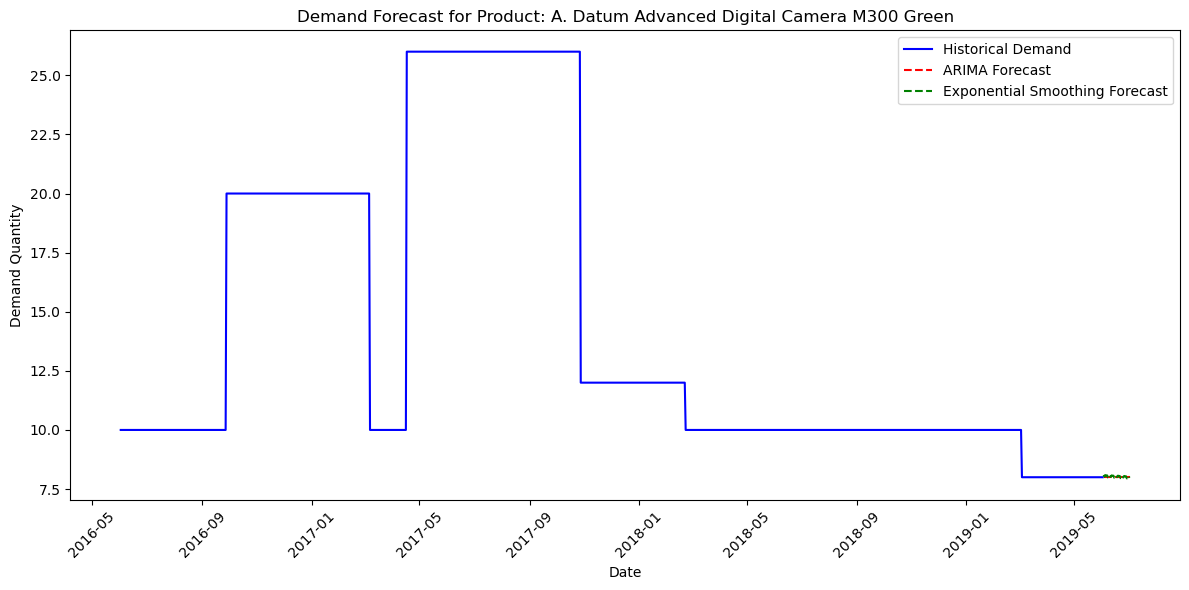

Historical demand stats for A. Datum Advanced Digital Camera M300 Green:
  Mean: 14.34
  Std: 6.47
  Max: 26.00
ARIMA forecast mean: 8.00
Exponential Smoothing forecast mean: 8.03

Making a sample price prediction...
Predicted Price: $319.72
Actual Price: $304.00
Difference: $15.72

Forecasting demand for product: A. Datum Advanced Digital Camera M300 Grey


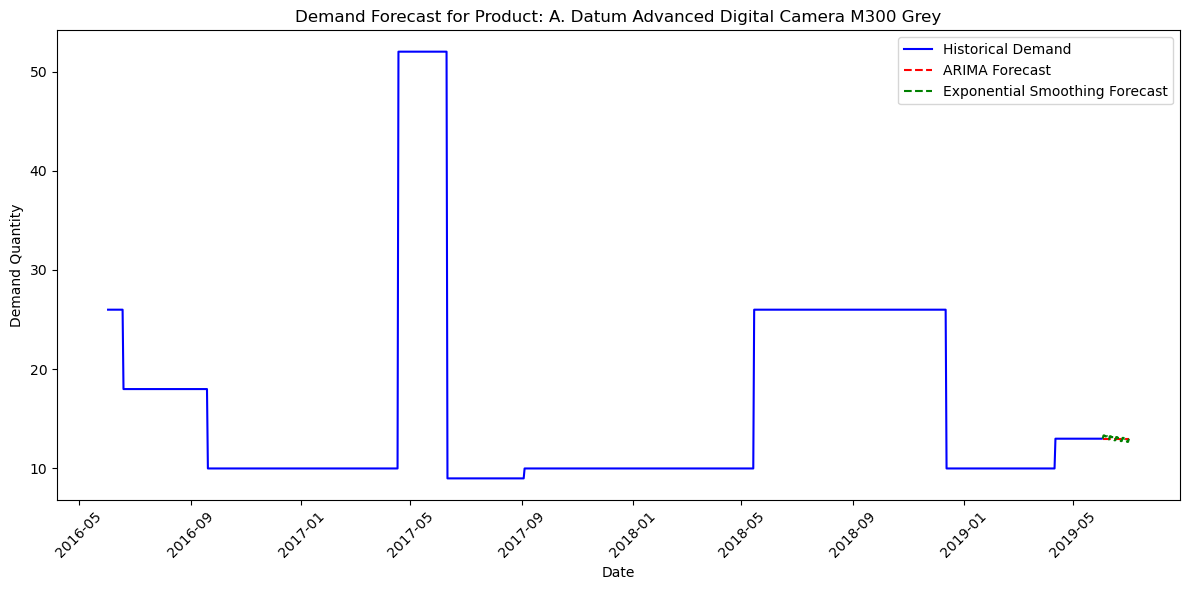

Historical demand stats for A. Datum Advanced Digital Camera M300 Grey:
  Mean: 16.16
  Std: 10.42
  Max: 52.00
ARIMA forecast mean: 13.00
Exponential Smoothing forecast mean: 13.05

Making a sample price prediction...
Predicted Price: $319.72
Actual Price: $304.00
Difference: $15.72

Forecasting demand for product: A. Datum Advanced Digital Camera M300 Orange


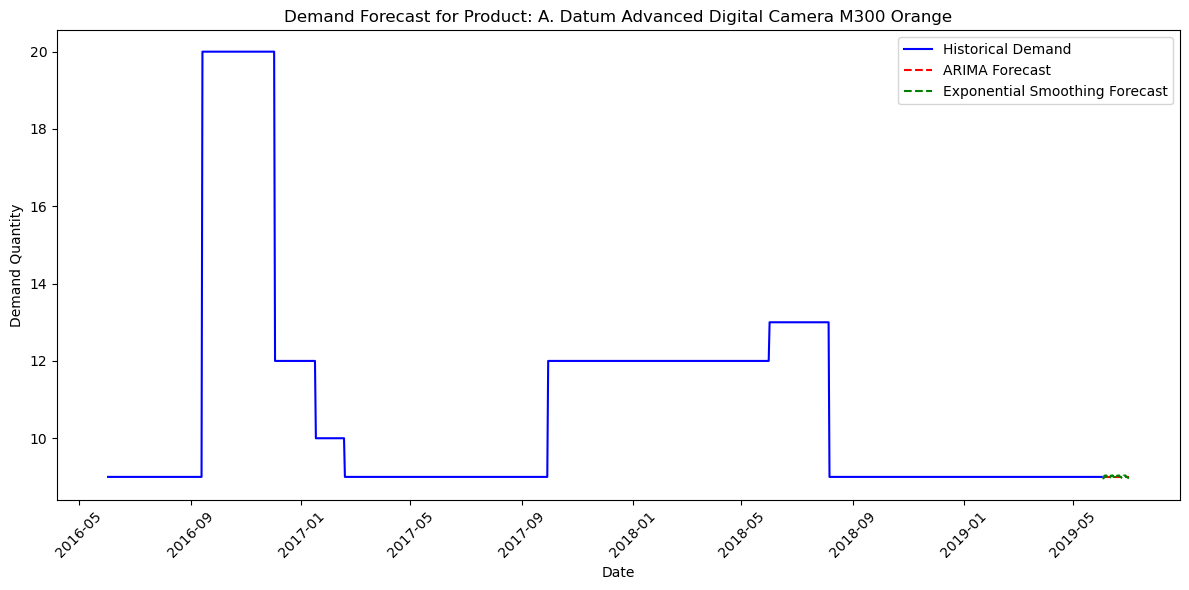

Historical demand stats for A. Datum Advanced Digital Camera M300 Orange:
  Mean: 10.86
  Std: 2.95
  Max: 20.00
ARIMA forecast mean: 9.00
Exponential Smoothing forecast mean: 9.00

Making a sample price prediction...
Predicted Price: $319.72
Actual Price: $304.00
Difference: $15.72


In [26]:
for product_name in product_names:
    print(f"\nForecasting demand for product: {product_name}")
    
    demand_forecast = forecast_demand(demand_pivot, product_name, periods=30)
    if demand_forecast:
           
        plot_demand_forecast(demand_forecast['historical_data'], demand_forecast, product_name)
            
        print(f"Historical demand stats for {product_name}:")
        print(f"  Mean: {demand_forecast['historical_data'].mean():.2f}")
        print(f"  Std: {demand_forecast['historical_data'].std():.2f}")
        print(f"  Max: {demand_forecast['historical_data'].max():.2f}")
            
        if demand_forecast['arima_forecast'] is not None:
            print(f"ARIMA forecast mean: {demand_forecast['arima_forecast'].mean():.2f}")
            
        if demand_forecast['exponential_smoothing_forecast'] is not None:
            print(f"Exponential Smoothing forecast mean: {demand_forecast['exponential_smoothing_forecast'].mean():.2f}")
                
            print("\nMaking a sample price prediction...")

            sample_data = X.iloc[0].to_dict()

            scaler = StandardScaler().fit(X)

            predicted_price = predict_price(best_model, scaler, sample_data, X.columns.tolist())

            actual_price = y.iloc[0]

            print(f"Predicted Price: ${predicted_price:.2f}")
            print(f"Actual Price: ${actual_price:.2f}")
            print(f"Difference: ${abs(predicted_price - actual_price):.2f}")

    

In [ ]:
product_names = demand_pivot.columns.tolist()[:5]
print(f"Forecasting demand for {len(product_names)} products...")
    
    

In [ ]:
    print("\nMaking a sample price prediction...")
    
    sample_data = X.iloc[0].to_dict()
    predicted_price = predict_price(best_model, StandardScaler().fit(X), sample_data, X.columns.tolist())
    actual_price = y.iloc[0]
    
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Actual Price: ${actual_price:.2f}")
    print(f"Difference: ${abs(predicted_price - actual_price):.2f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=demand_data['Price'], y=demand_data['Order Qty'], alpha=0.5)
    plt.title('Price vs Demand Relationship')
    plt.xlabel('Price')
    plt.ylabel('Demand Quantity')
    plt.tight_layout()
    plt.show()

In [ ]:
df.columns
